# Computing Partial Derivatives for Neural Networks

### Setup

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots
plt.rcParams['agg.path.chunksize'] = 10000
%config InlineBackend.figure_format = 'retina'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_palette("bright")

### Helper methods

In [2]:
def model(x, reuse=False):
    """
    2 Hidden Layer (5 x 5) neural network with RELU activation.
    """
    fc1 = layers.fully_connected(x, 5, activation_fn=tf.nn.relu, scope='fc1', reuse=reuse)
    fc2 = layers.fully_connected(fc1, 5, activation_fn=tf.nn.relu, scope='fc2', reuse=reuse)
    y = layers.fully_connected(fc2, 1, activation_fn=None, scope='fc3', reuse=reuse)
    return y

def preprocess(X):
    """
    Scales and shifts X to have 0 mean and unit variance.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

def get_data(df, X_vars, y_var, train_test_split=1.0):
    """
    Gets normalized features and the response variable from the dataframe.
    
    Args:
      - df: Pandas dataframe containing the input data.
      - X_vars: List of column names for the input matrix.
      - y_var: Column name for the output matrix.
      - train_test_split: Percentage of data to go in train.
    
    Returns:
        - X: Normalized input matrix containing X_vars.
        - y: Array containing the response variable.
        - X_scaler: Module used to normalize X.
    """
    # Filter out rows where one of the input variables and/or response variable is NaN.
    df = df[X_vars + [y_var]].dropna()
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:int(df.shape[0] * train_test_split)]
    df_test = df.iloc[int(df.shape[0] * train_test_split):]
    X_train, X_scaler = preprocess(df_train[X_vars])
    X_test = X_scaler.transform(df_test[X_vars])
    y_train = df_train[y_var]
    y_test = df_test[y_var]
    return X_train, y_train, X_test, y_test, X_scaler

### Read the data

In [3]:
US_Var_df = pd.read_csv("biomet_data/AMF_US-Var_BASE_HH_9-1.csv", comment = "#").replace("-9999", np.nan)
US_Ton_df = pd.read_csv("biomet_data/AMF_US-Ton_BASE_HH_9-1.csv", comment = "#").replace("-9999", np.nan)
print "Var Data: ", US_Var_df.shape
print "Tonzi Data: ", US_Ton_df.shape
print "Columns: ", US_Var_df.columns

Var Data:  (280512, 38)
Tonzi Data:  (186419, 38)
Columns:  Index([u'TIMESTAMP_START', u'TIMESTAMP_END', u'USTAR', u'TA', u'WD', u'WS',
       u'NEE_PI', u'FC', u'SC', u'H', u'SH', u'LE', u'SLE', u'G', u'TS_1',
       u'TS_2', u'P', u'RH', u'PA', u'CO2_1', u'CO2_2', u'VPD_PI', u'SWC_1',
       u'SWC_2', u'NETRAD', u'PPFD_IN', u'SW_IN', u'SW_DIF', u'PPFD_OUT',
       u'SW_OUT', u'LW_IN', u'LW_OUT', u'H2O', u'RECO_PI', u'APAR',
       u'PPFD_DIF', u'FAPAR', u'ZL'],
      dtype='object')


### Display features and response variable

In [4]:
X_vars, y_var, train_test_split = ['TA', 'SW_IN', 'RH'], 'NETRAD', 0.8
X_train, y_train, X_val, y_val, X_scaler = get_data(US_Var_df, X_vars, y_var, train_test_split)
print "X_train: ", X_train.shape
if X_train.shape[1] == 1:
    plt.scatter(X_scaler.inverse_transform(X_train), y_train)
    plt.xlabel(X_vars[0])
    plt.ylabel(y_var)
    plt.show()
    plt.xlabel(X_vars[0])
    sns.kdeplot(X_scaler.inverse_transform(X_train[:20000, 0]), y_train[:20000], cmap="Blues", shade=True, shade_lowest=False)
elif X_train.shape[1] == 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     ax.xlim([-20,20])
    ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
else:
    print "Cannot plot data when in {0}-D!".format(X_train.shape[1] + 1)

X_train:  (180247, 3)
Cannot plot data when in 4-D!


In [5]:
X_uniform = np.mgrid[-2:2.01:0.08, -2:2.01:0.08, -2:2.01:0.08].reshape(3,-1).T
print X_uniform.shape

(132651, 3)


In [6]:
X_gaussian = np.random.multivariate_normal([0, 0, 0], np.diag([1, 1, 1]), 50000)

### Train Neural Network, Compute Partials, Plot Result

Using a 80/20 split on the training data, I trained a 5x5 2 hidden layer neural network with a batch size of 256. I then computed the predictions and partial derivatives w.r.t. input on the validation set. As you may observe, the neural network tries to predict the mean of the response distribution at any given x. For the currently chosen parameters, this results in a negative almost straight line. The partial derivatives as a result are constant for many segments of x.

In [7]:
# Split the data into batches
batch_size = 256
num_batches = X_train.shape[0] / batch_size
X_batches = np.array_split(X_train, num_batches)
y_batches = np.array_split(y_train.values.reshape(-1, 1), num_batches)

# Placeholders for the 
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
y = tf.placeholder(tf.float32, shape=[None, 1])
y_pred = model(X, reuse=False)

# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.GradientDescentOptimizer(0.00001)
train = optimizer.minimize(loss)

# Compute partial derivative of predictions w.r.t. input.
partial_x = tf.gradients(y_pred, X)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
sess = tf.Session()
sess.run(init)

with tf.Graph().as_default(), sess.as_default():
    for epoch in xrange(30):
        for i in xrange(num_batches):
            # Train on batch i.
            _, batch_loss = sess.run([train, loss], feed_dict={X: X_batches[i], y: y_batches[i]})
            if i % 500 == 0:
                print "Epoch: ", epoch, "Batch: ", i, "MSE: ", batch_loss
    
    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    uniform_preds, uniform_partials = sess.run([y_pred, partial_x], feed_dict={X: X_uniform})
    gauss_preds, gauss_partials = sess.run([y_pred, partial_x], feed_dict={X: X_gaussian})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:  0 Batch:  0 MSE:  54775.1
Epoch:  0 Batch:  500 MSE:  5633.37
Epoch:  1 Batch:  0 MSE:  2335.7
Epoch:  1 Batch:  500 MSE:  2426.52
Epoch:  2 Batch:  0 MSE:  2225.27
Epoch:  2 Batch:  500 MSE:  2408.25
Epoch:  3 Batch:  0 MSE:  2210.83
Epoch:  3 Batch:  500 MSE:  2388.7
Epoch:  4 Batch:  0 MSE:  2194.76
Epoch:  4 Batch:  500 MSE:  2368.78
Epoch:  5 Batch:  0 MSE:  2179.19
Epoch:  5 Batch:  500 MSE:  2348.73
Epoch:  6 Batch:  0 MSE:  2162.15
Epoch:  6 Batch:  500 MSE:  2326.56
Epoch:  7 Batch:  0 MSE:  2143.24
Epoch:  7 Batch:  500 MSE:  2301.57
Epoch:  8 Batch:  0 MSE:  2121.65
Epoch:  8 Batch:  500 MSE:  2269.84
Epoch:  9 Batch:  0 MSE:  2093.18
Epoch:  9 Batch:  500 MSE:  2223.02
Epoch:  10 Batch:  0 MSE:  2048.64
Epoch:  10 Batch:  500 MSE:  2133.85
Epoch:  11 Batch:  0 MSE:  1957.62
Epoch:  11 Batch:  500 MSE:  1899.91
Epoch:  12 Batch:  0 MSE:  1702.34
Epoch:  12 Batch:  500 MSE:  1352.0
Epoch:  13 Ba

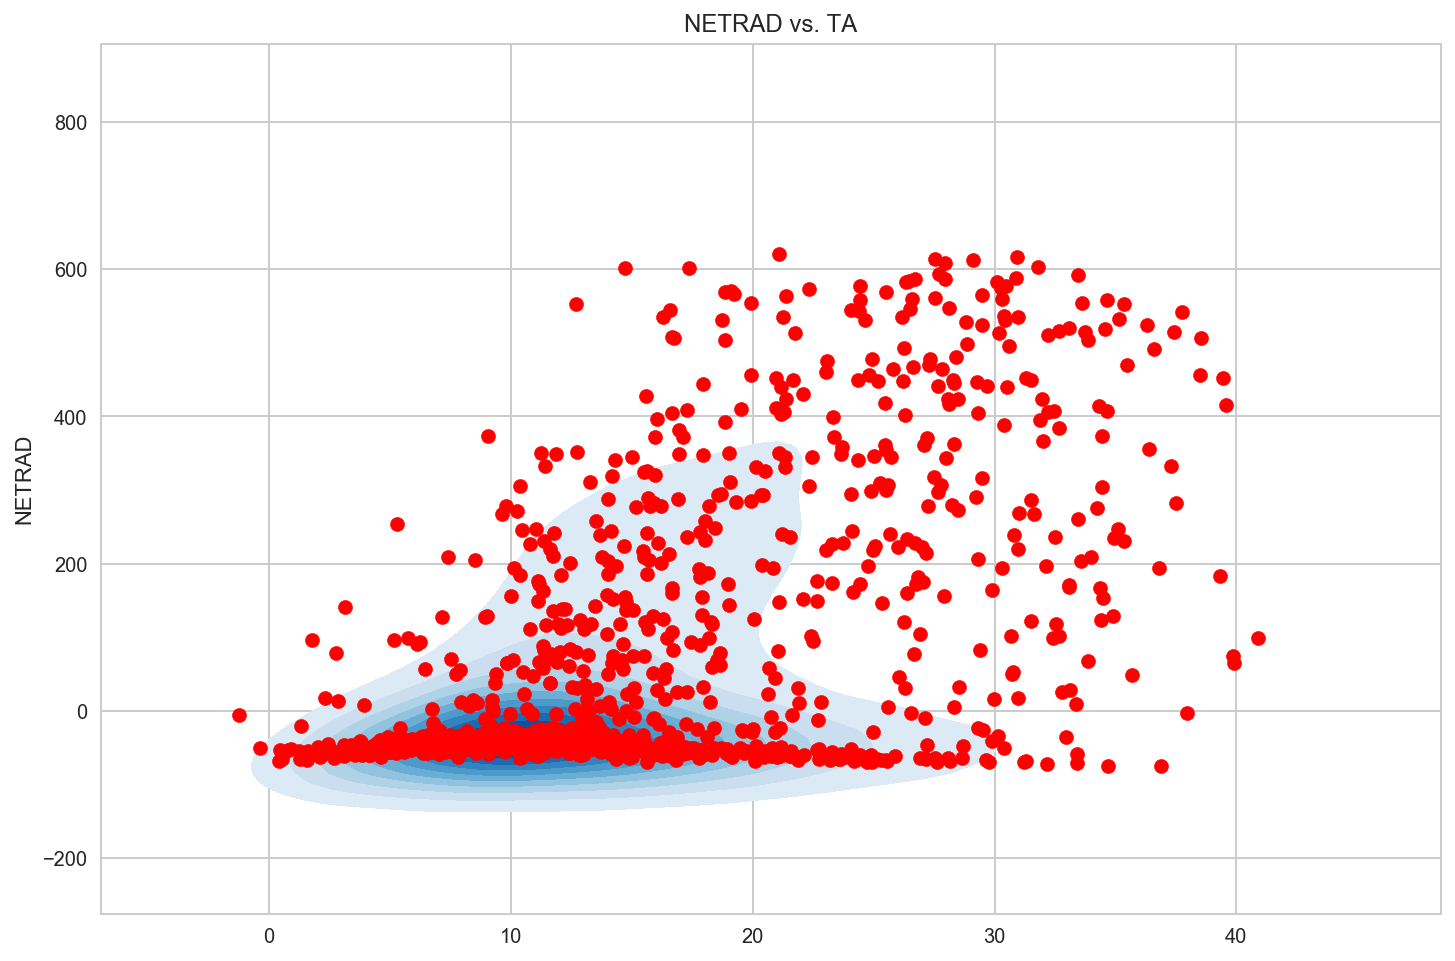

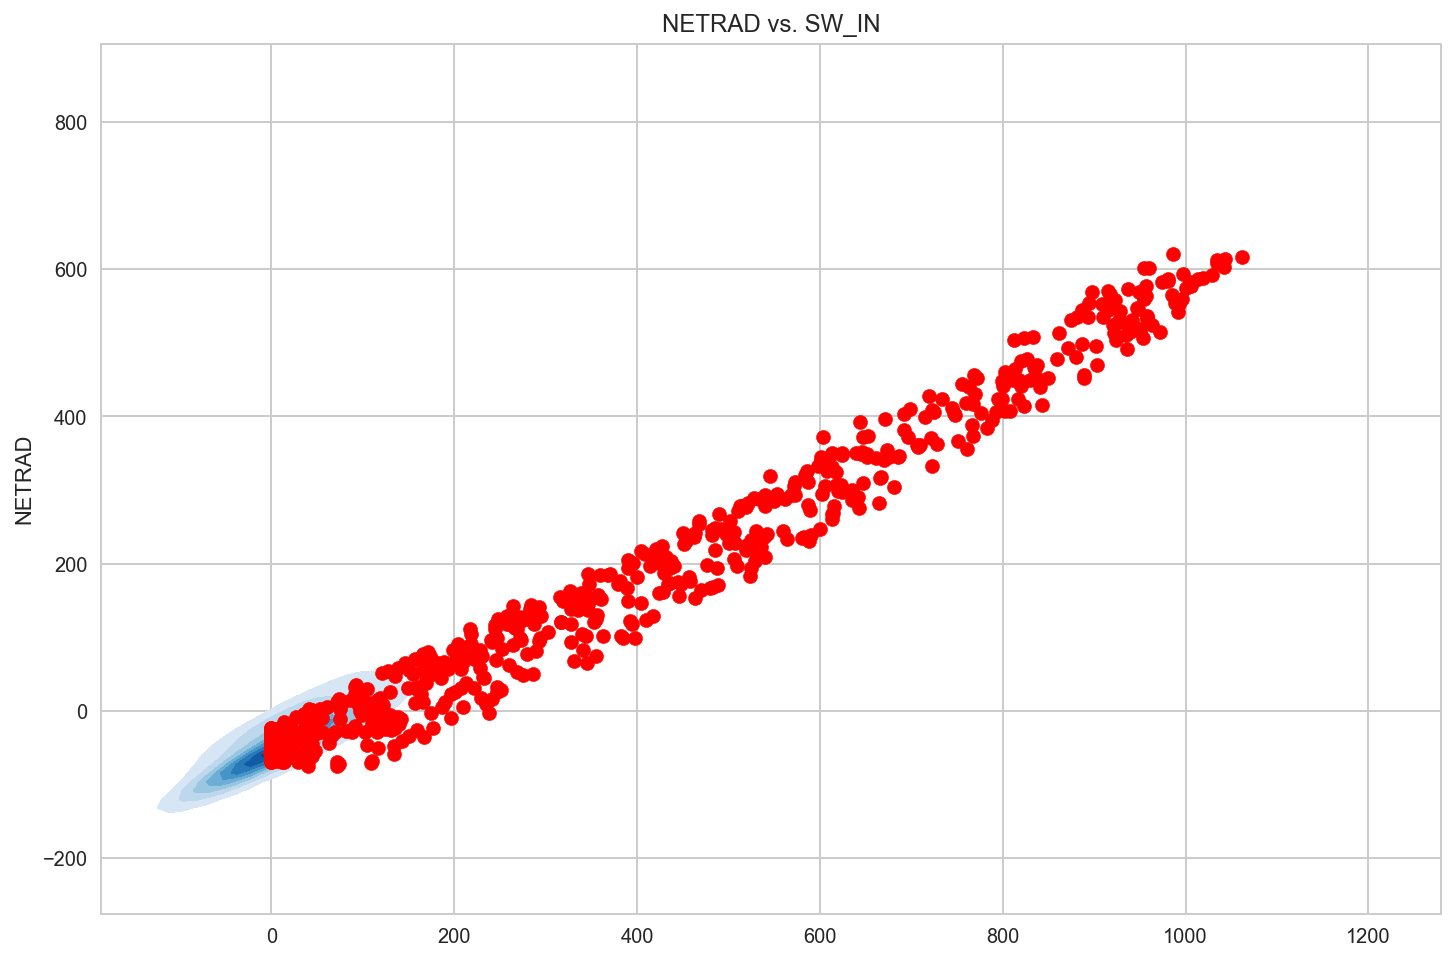

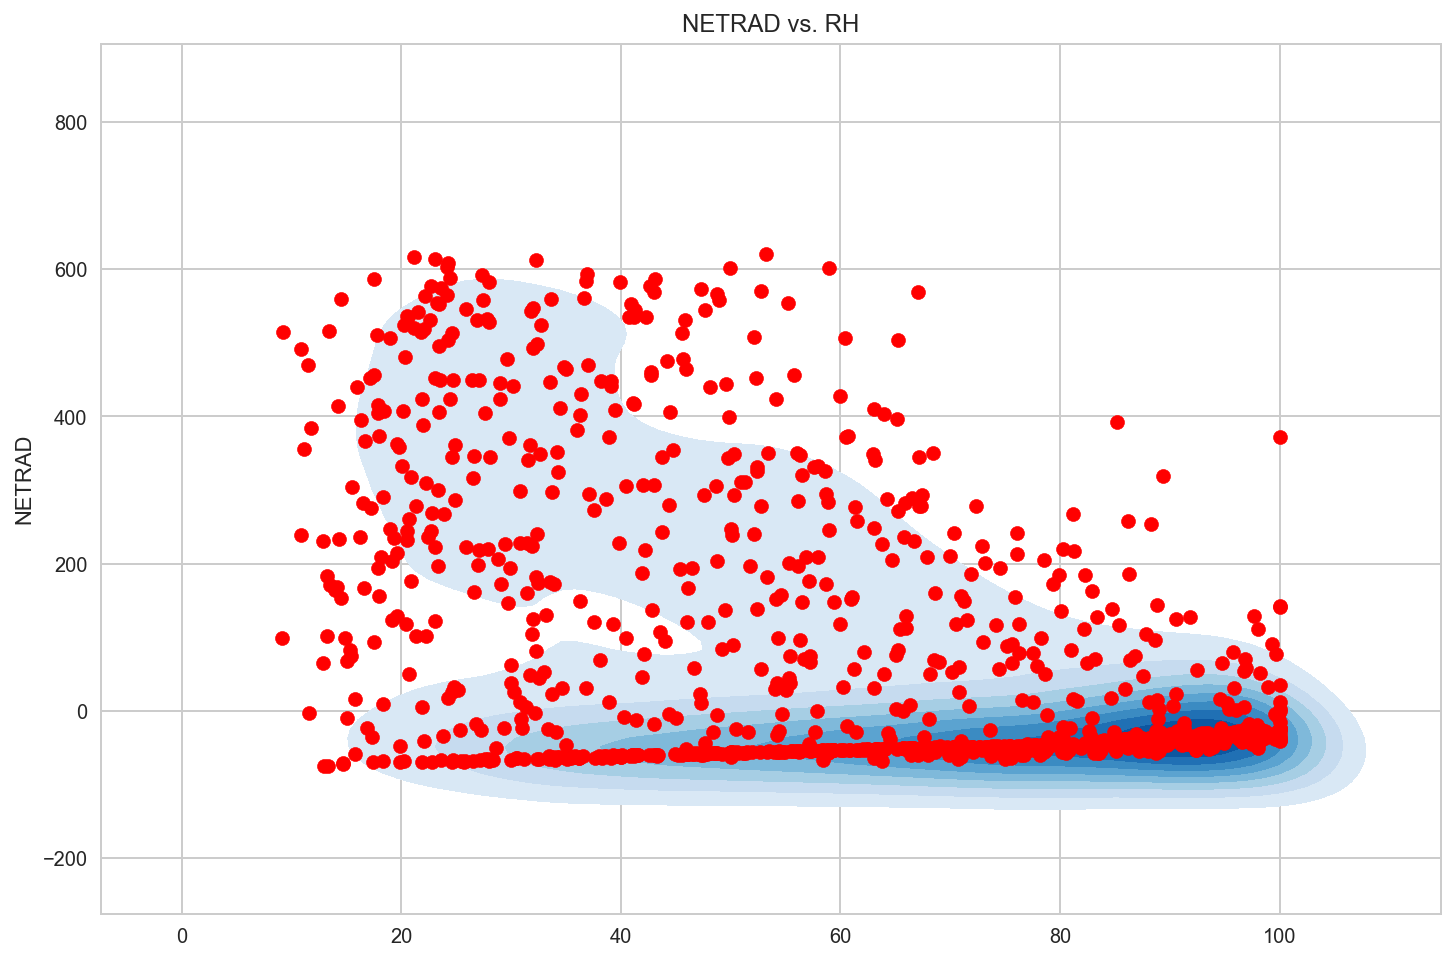

In [8]:
# Plot the first 20000 samples for KDE and 1000 for preds, already randomly shuffled, to save performance.
plt.title("NETRAD vs. TA")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:20000, 0], y_val[:20000], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:1000, 0], preds[:1000, 0], c='r')
plt.show()
plt.title("NETRAD vs. SW_IN")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:20000, 1], y_val[:20000], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:1000, 1], preds[:1000, 0], c='r')
plt.show()
plt.title("NETRAD vs. RH")
sns.kdeplot(X_scaler.inverse_transform(X_val)[:20000, 2], y_val[:20000], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_val)[:1000, 2], preds[:1000, 0], c='r')
plt.show()

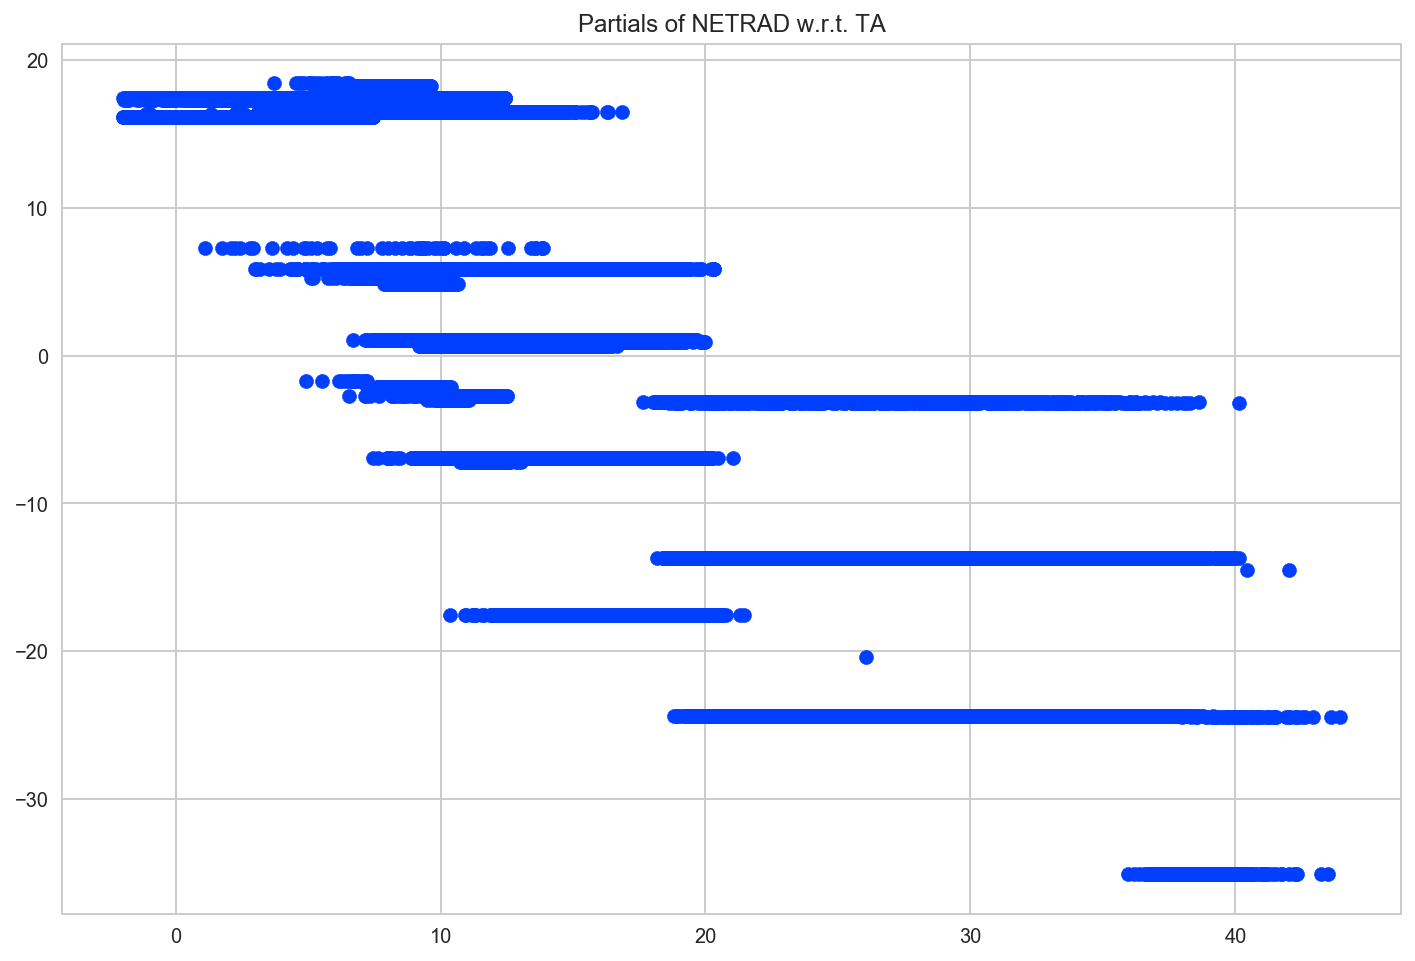

In [9]:
plt.title("Partials of NETRAD w.r.t. TA")
plt.scatter(X_scaler.inverse_transform(X_val)[:, 0], partials[0][:, 0])

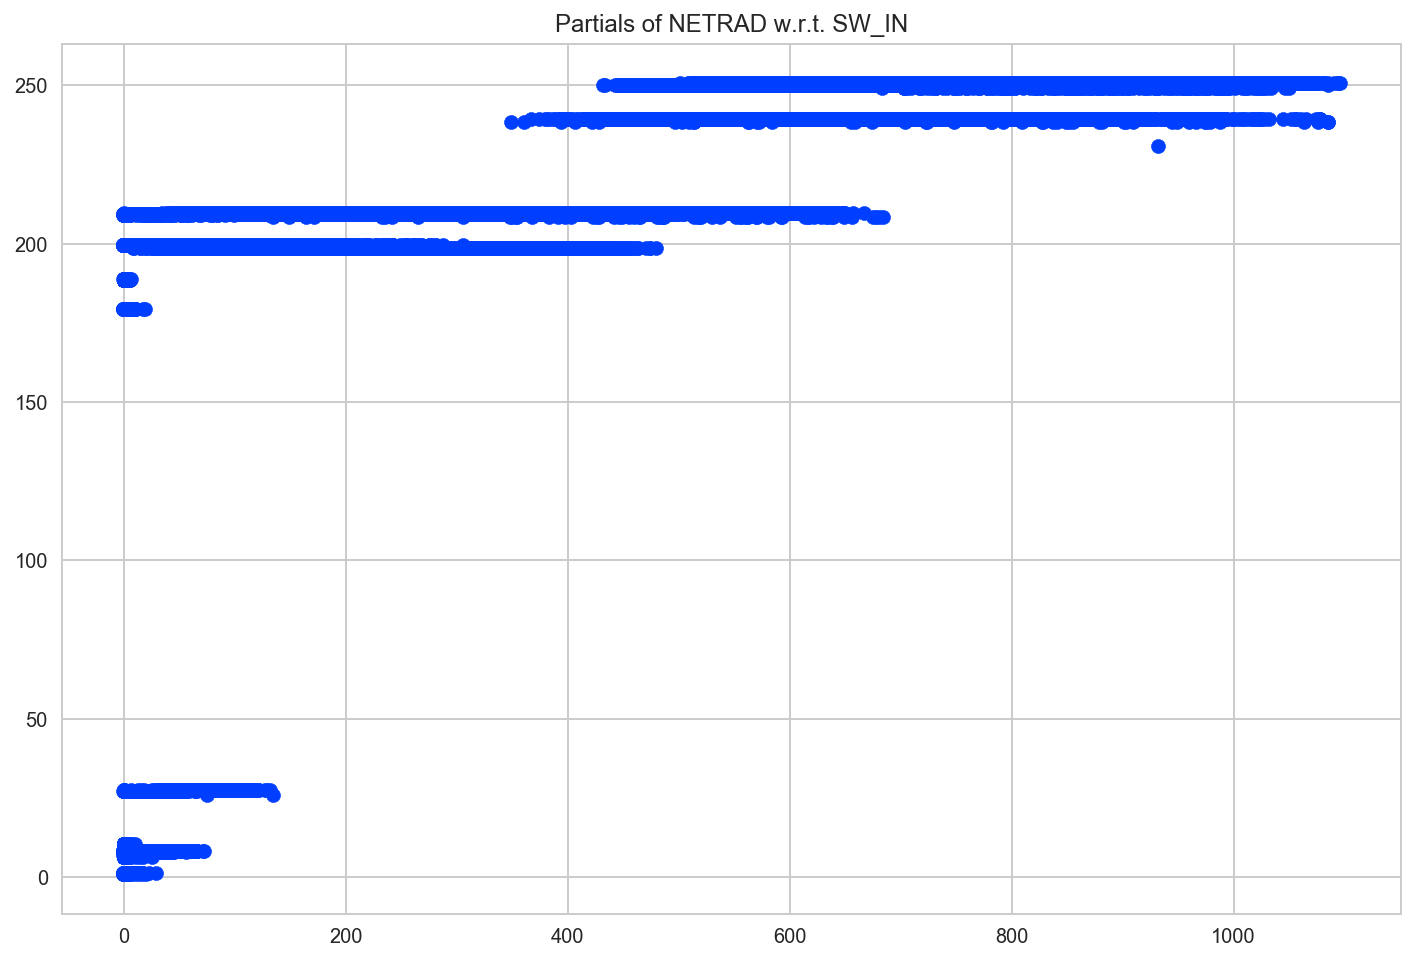

In [10]:
plt.title("Partials of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_val)[:, 1], partials[0][:, 1])

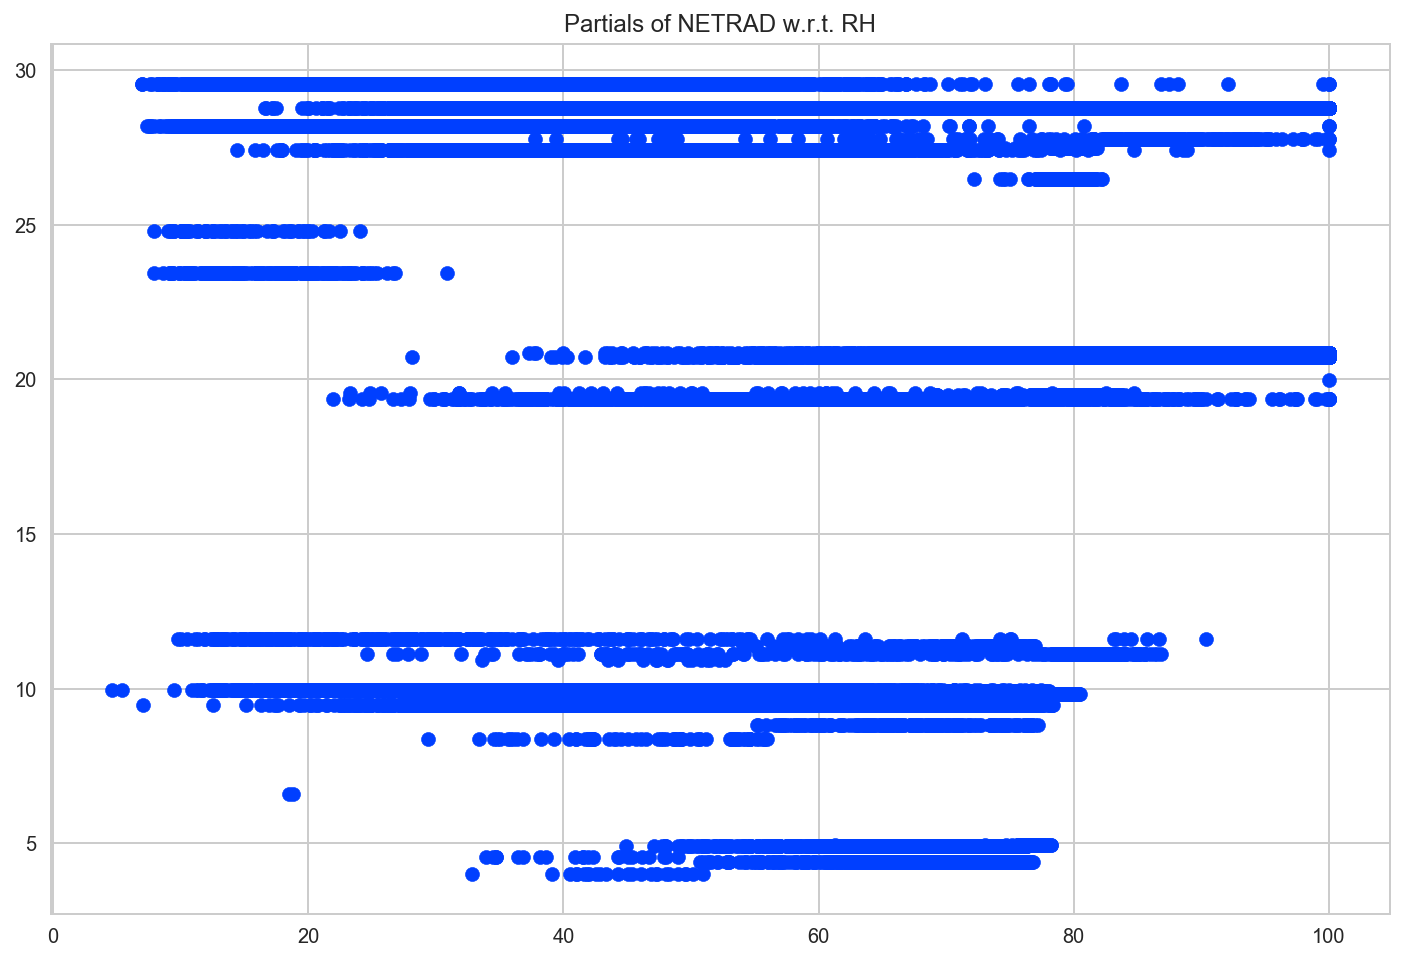

In [11]:
plt.title("Partials of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_val)[:, 2], partials[0][:, 2])

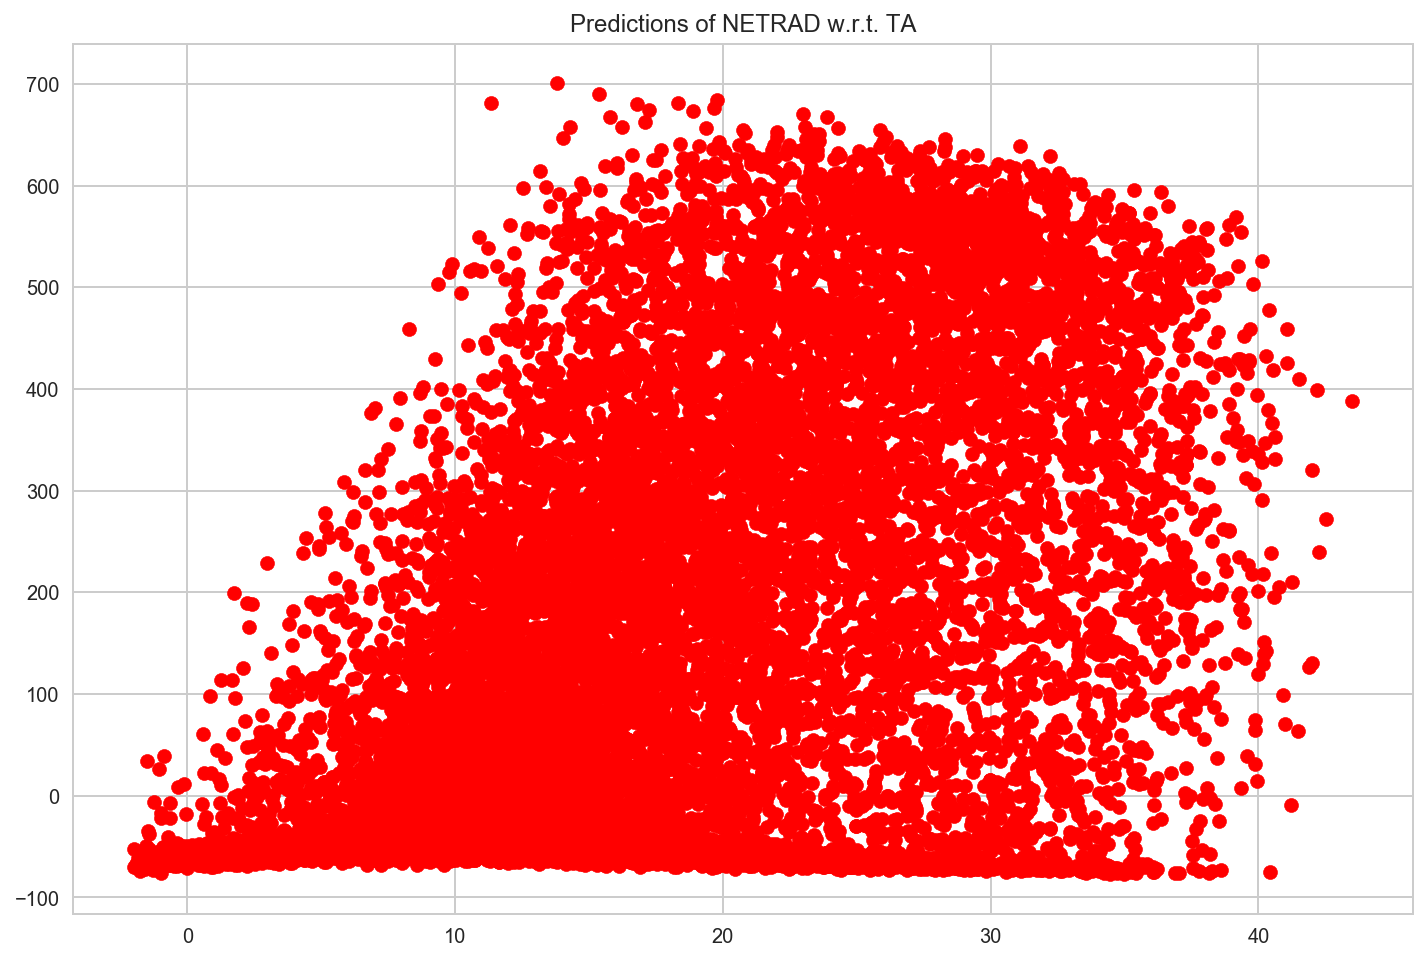

In [12]:
plt.title("Predictions of NETRAD w.r.t. TA")
plt.scatter(X_scaler.inverse_transform(X_val)[:20000, 0], preds[:20000, 0], c='r')

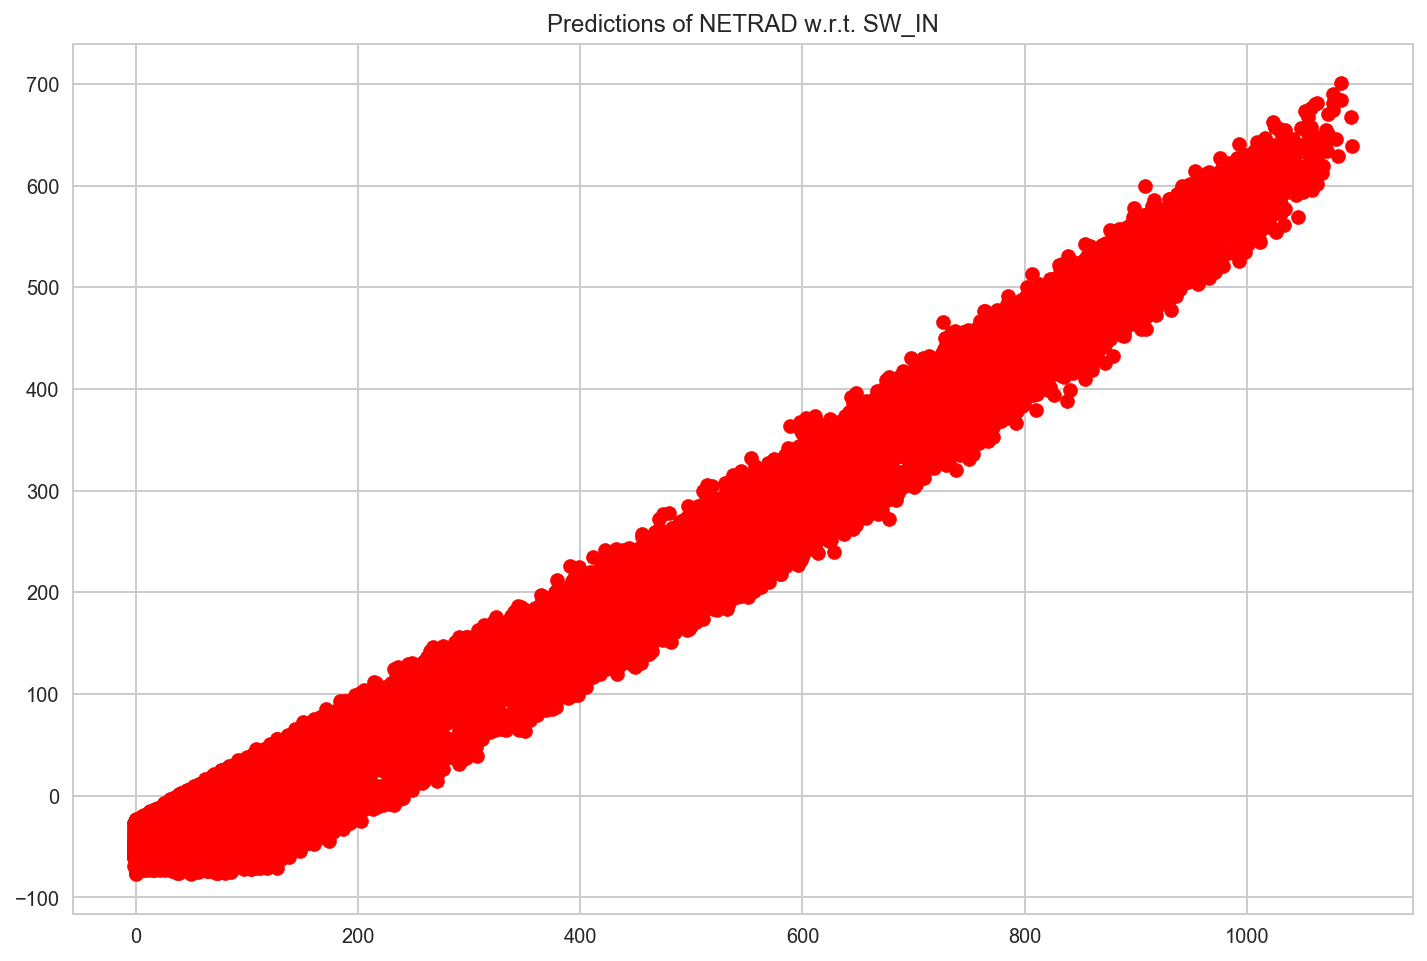

In [13]:
plt.title("Predictions of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_val)[:20000, 1], preds[:20000, 0], c='r')

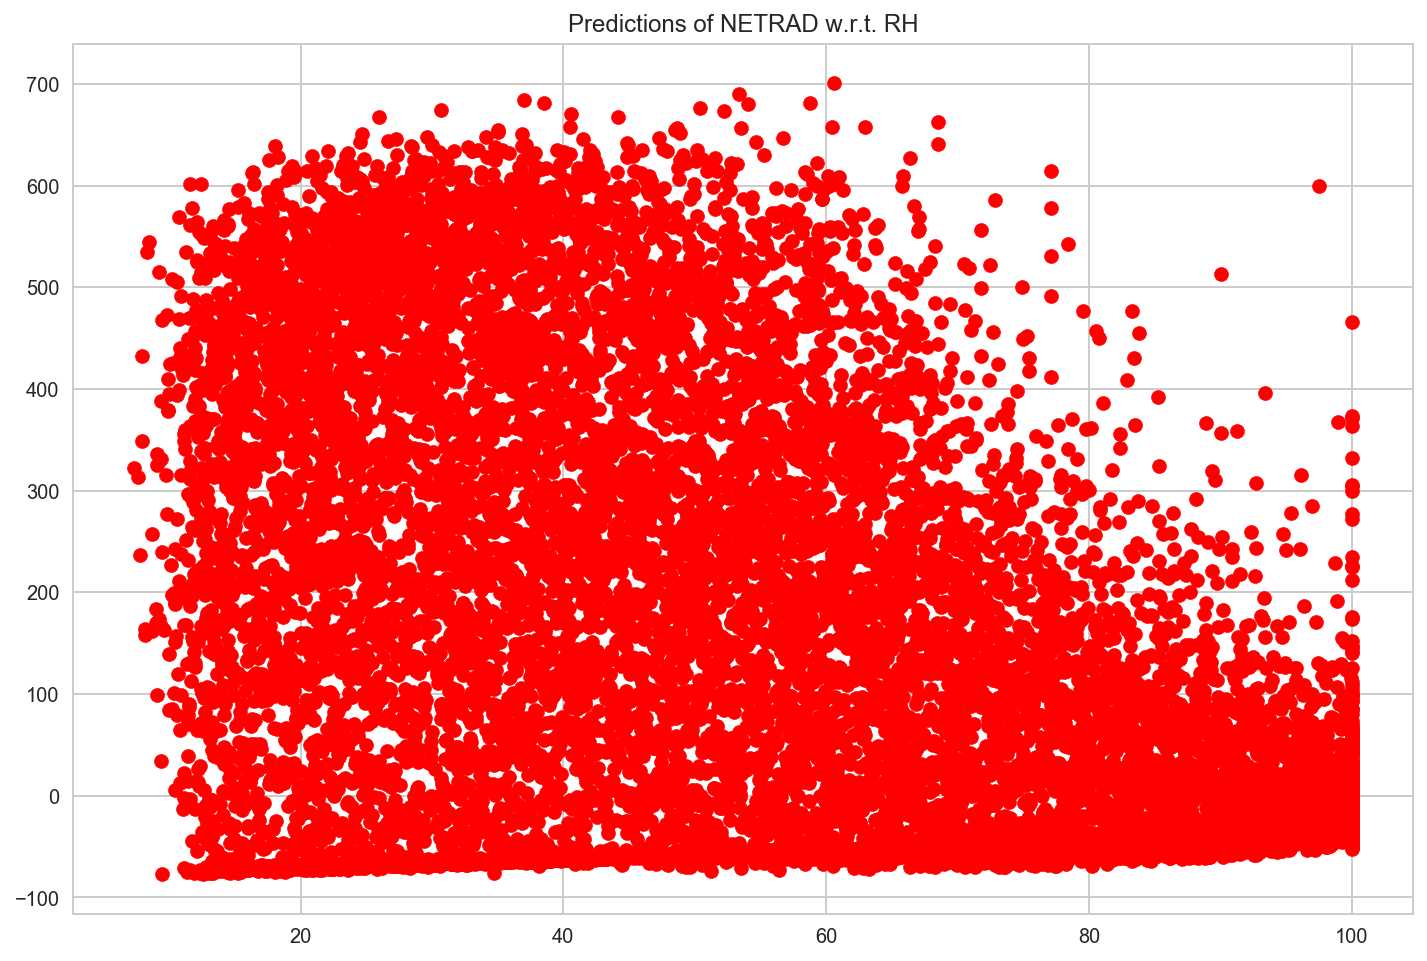

In [14]:
plt.title("Predictions of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_val)[:20000, 2], preds[:20000, 0], c='r')

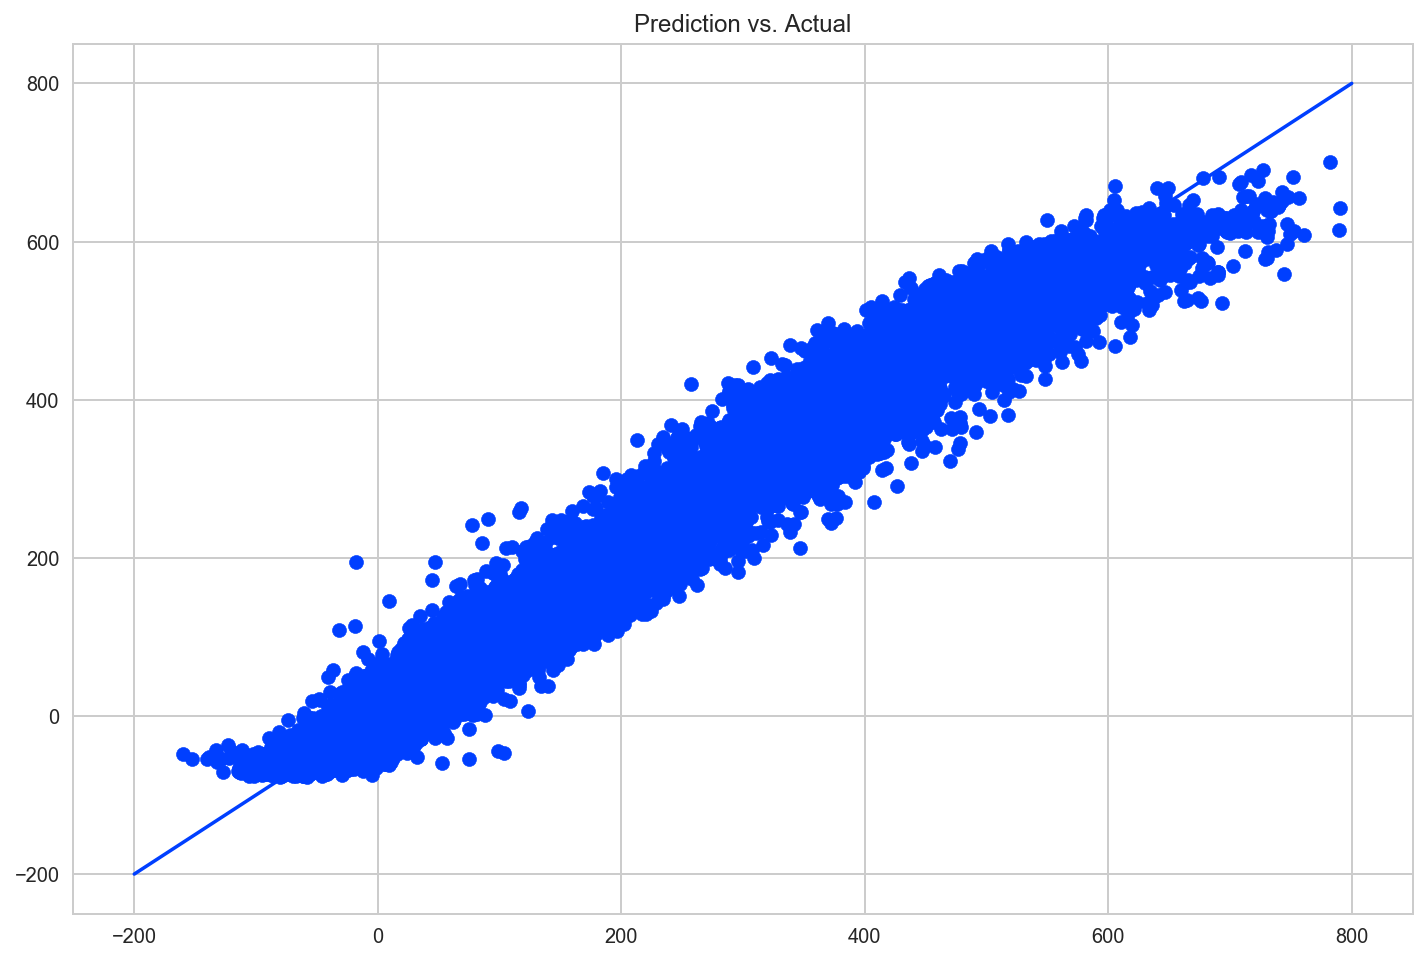

In [15]:
plt.title("Prediction vs. Actual")
plt.scatter(y_val[:20000], preds[:20000])
plt.plot([-200, 800], [-200, 800])

## Uniform Predictions/Partials

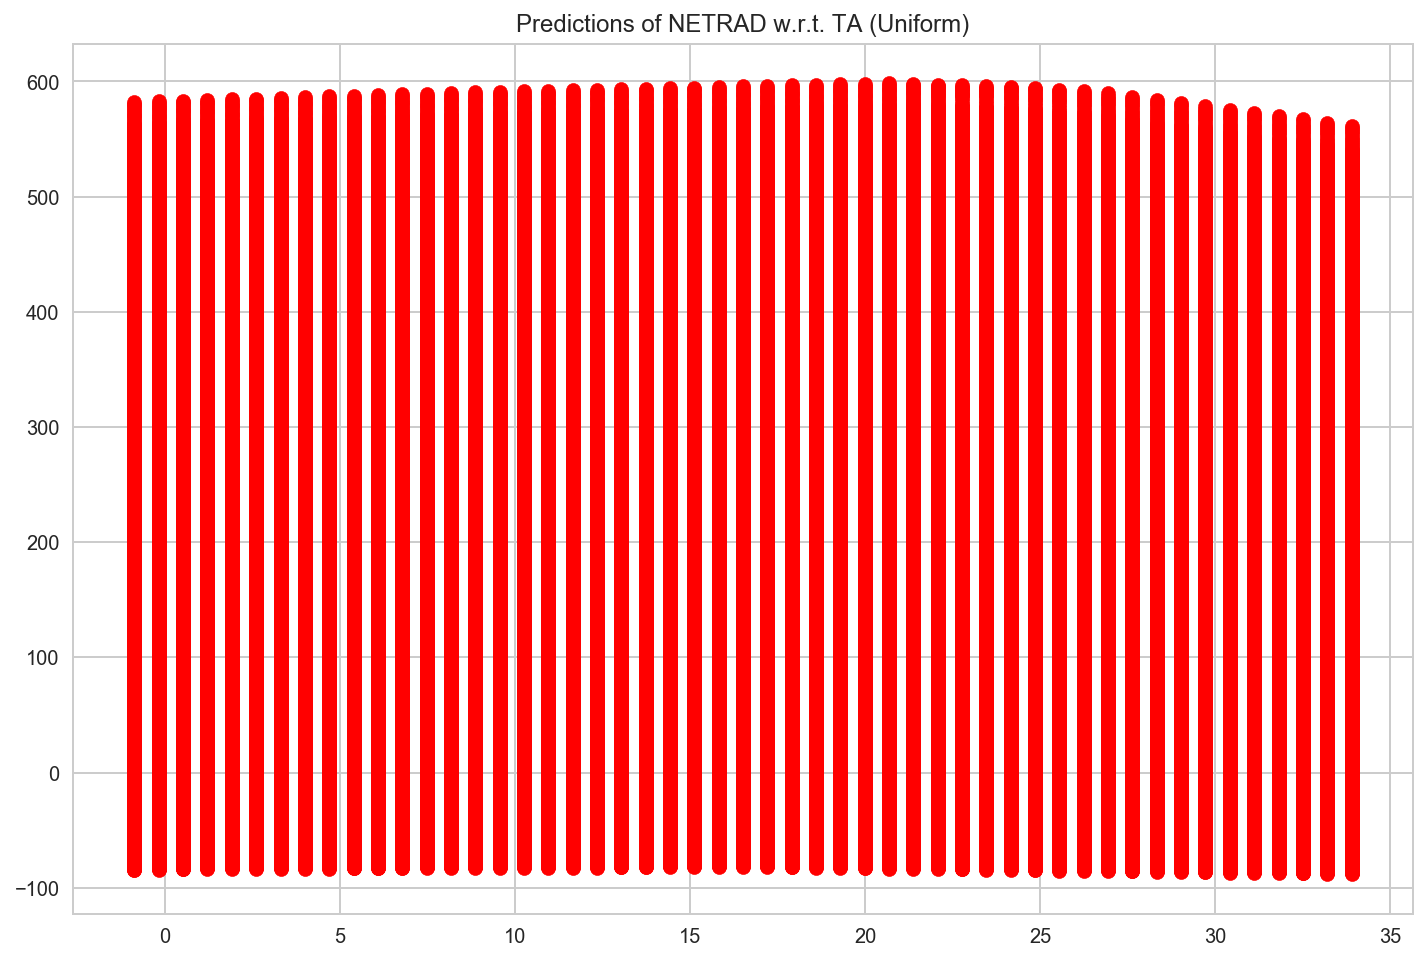

In [16]:
plt.title("Predictions of NETRAD w.r.t. TA (Uniform)")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 0], uniform_preds[:, 0], c='r')

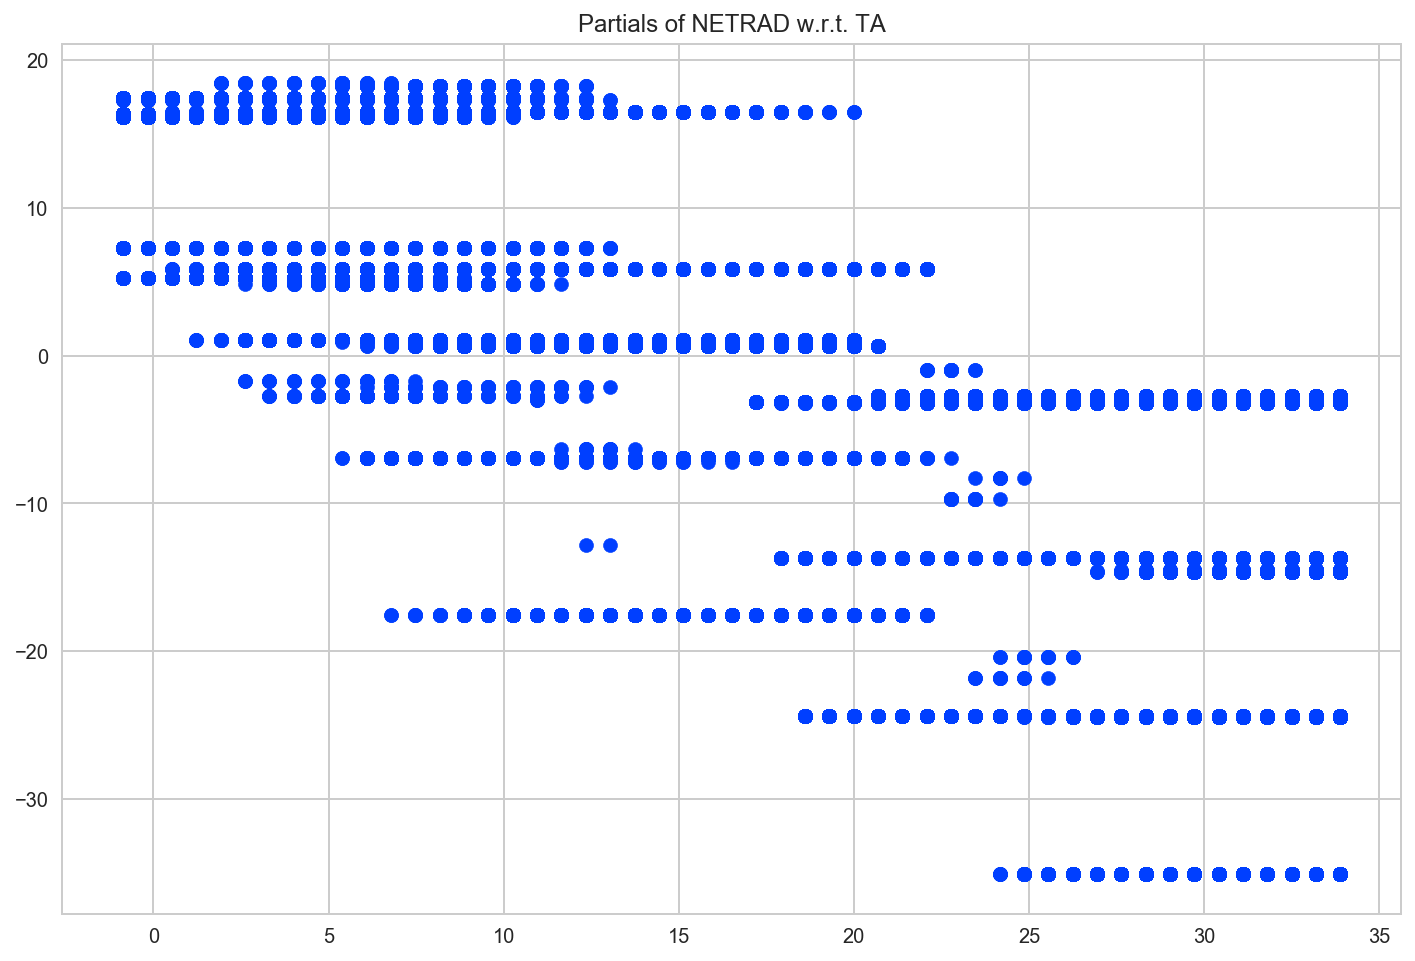

In [17]:
plt.title("Partials of NETRAD w.r.t. TA")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 0], uniform_partials[0][:, 0])

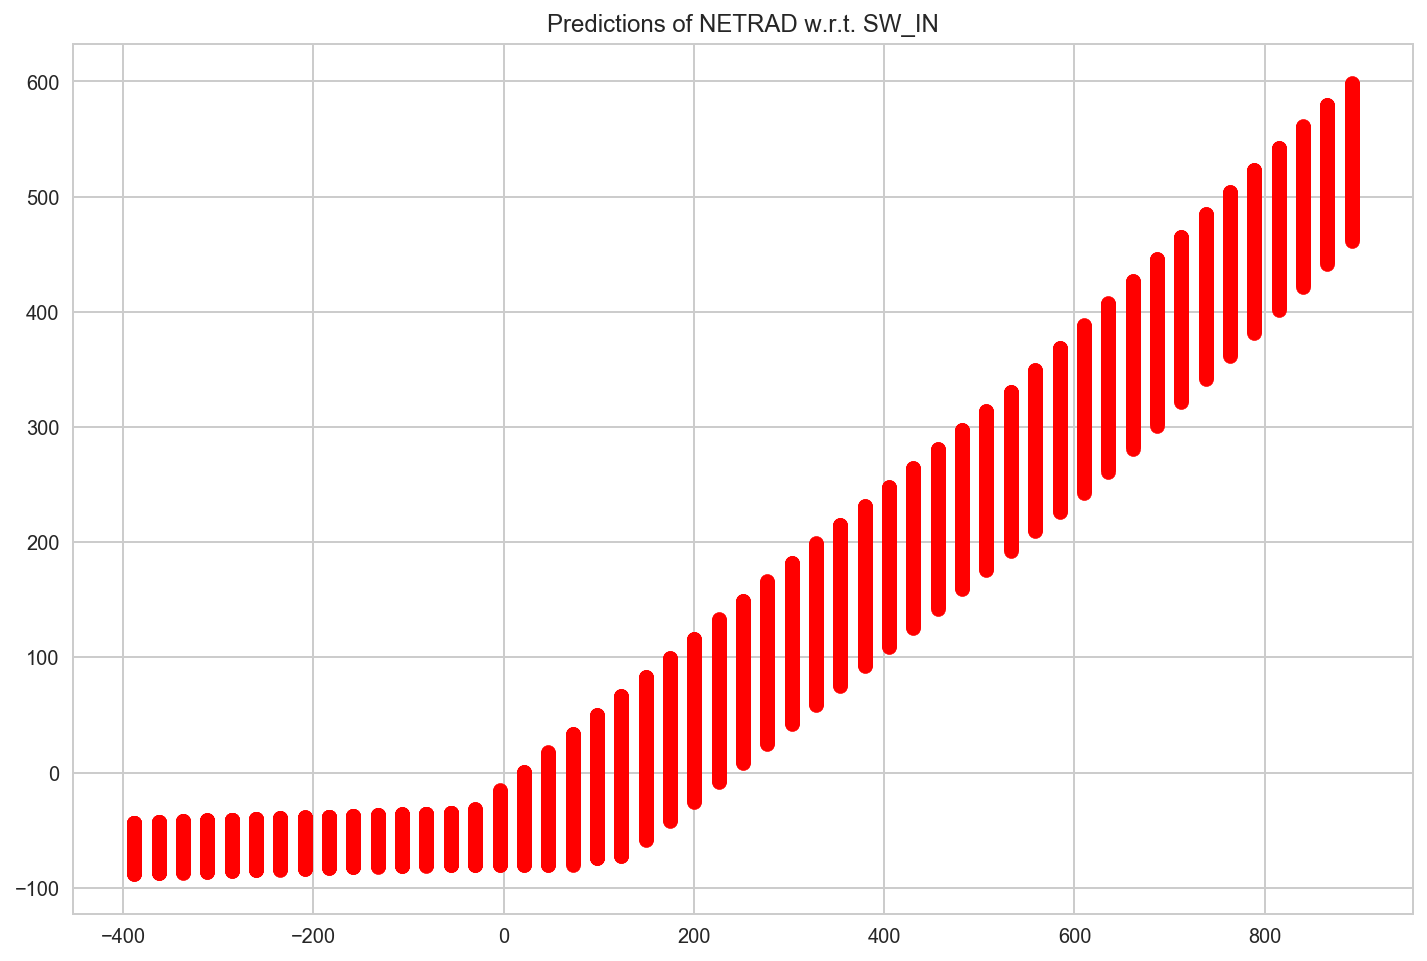

In [19]:
plt.title("Predictions of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 1], uniform_preds[:, 0], c='r')

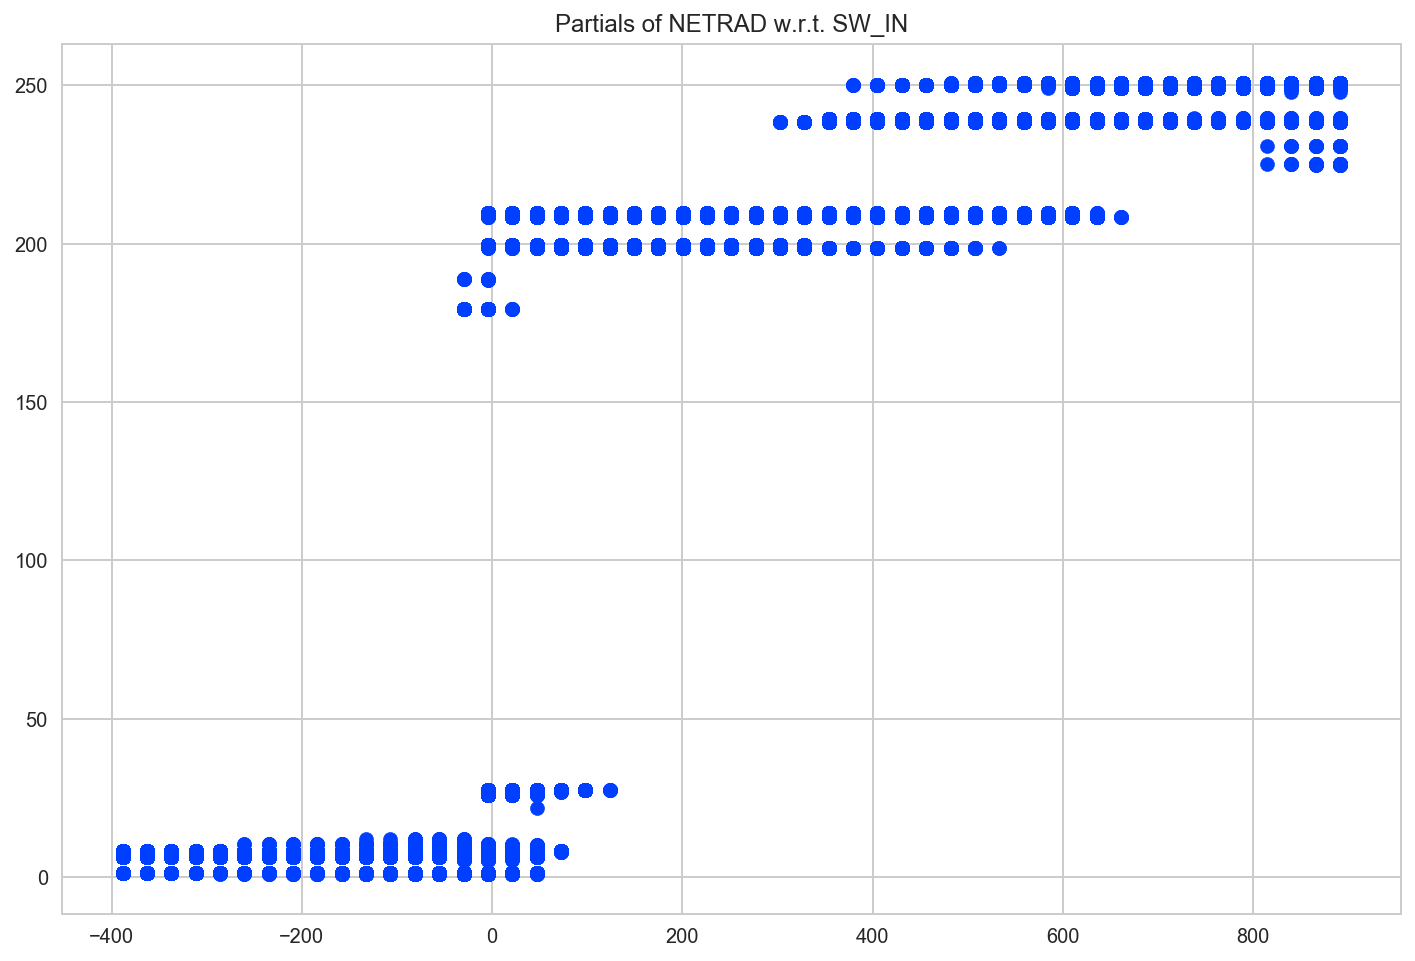

In [20]:
plt.title("Partials of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 1], uniform_partials[0][:, 1])

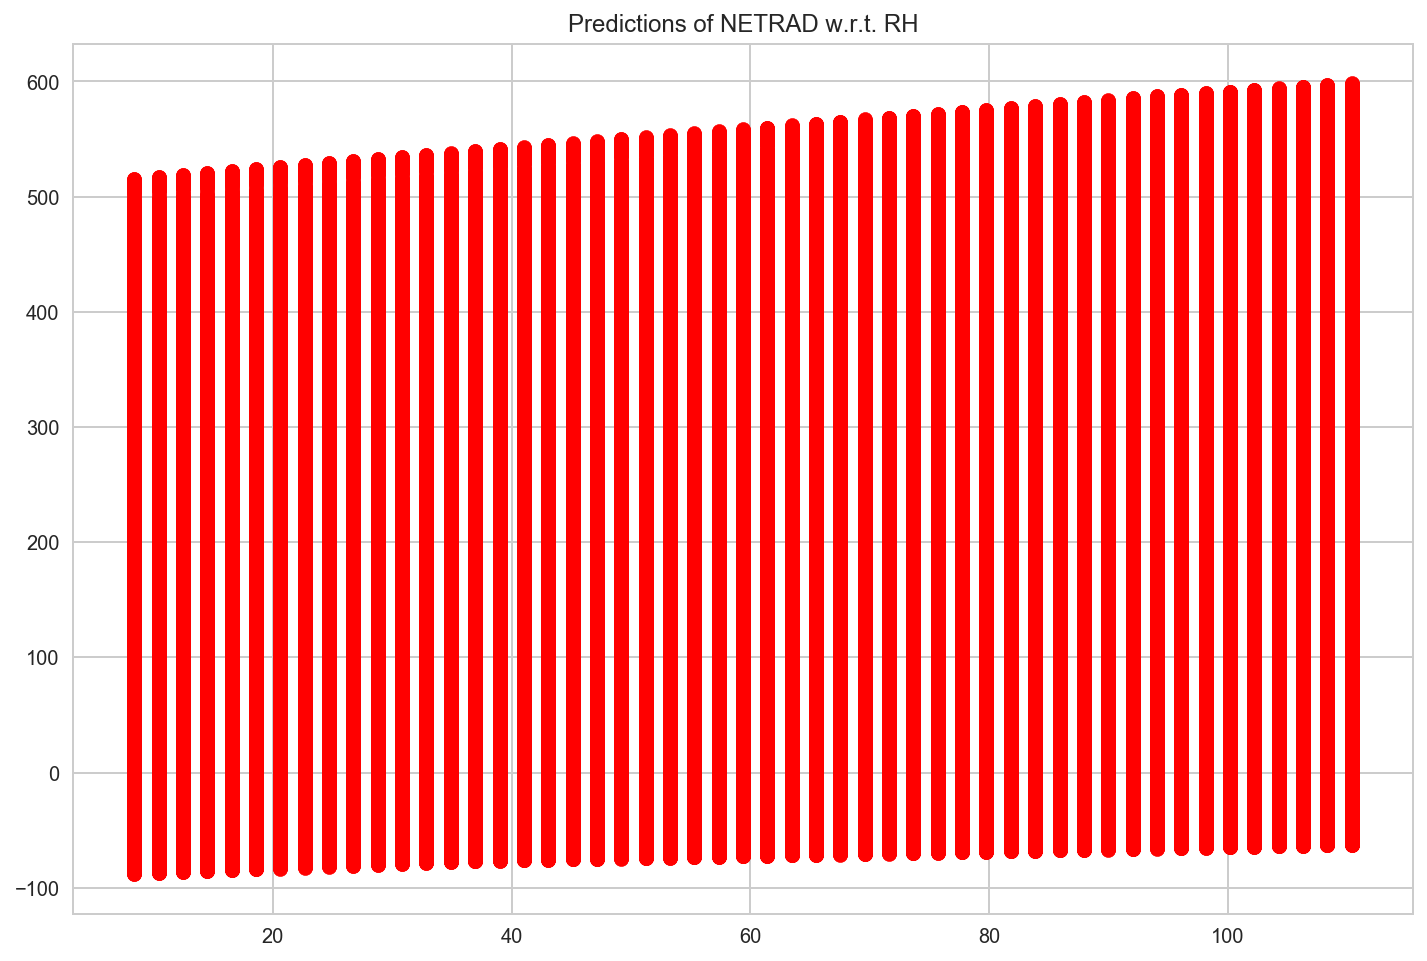

In [21]:
plt.title("Predictions of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 2], uniform_preds[:, 0], c='r')

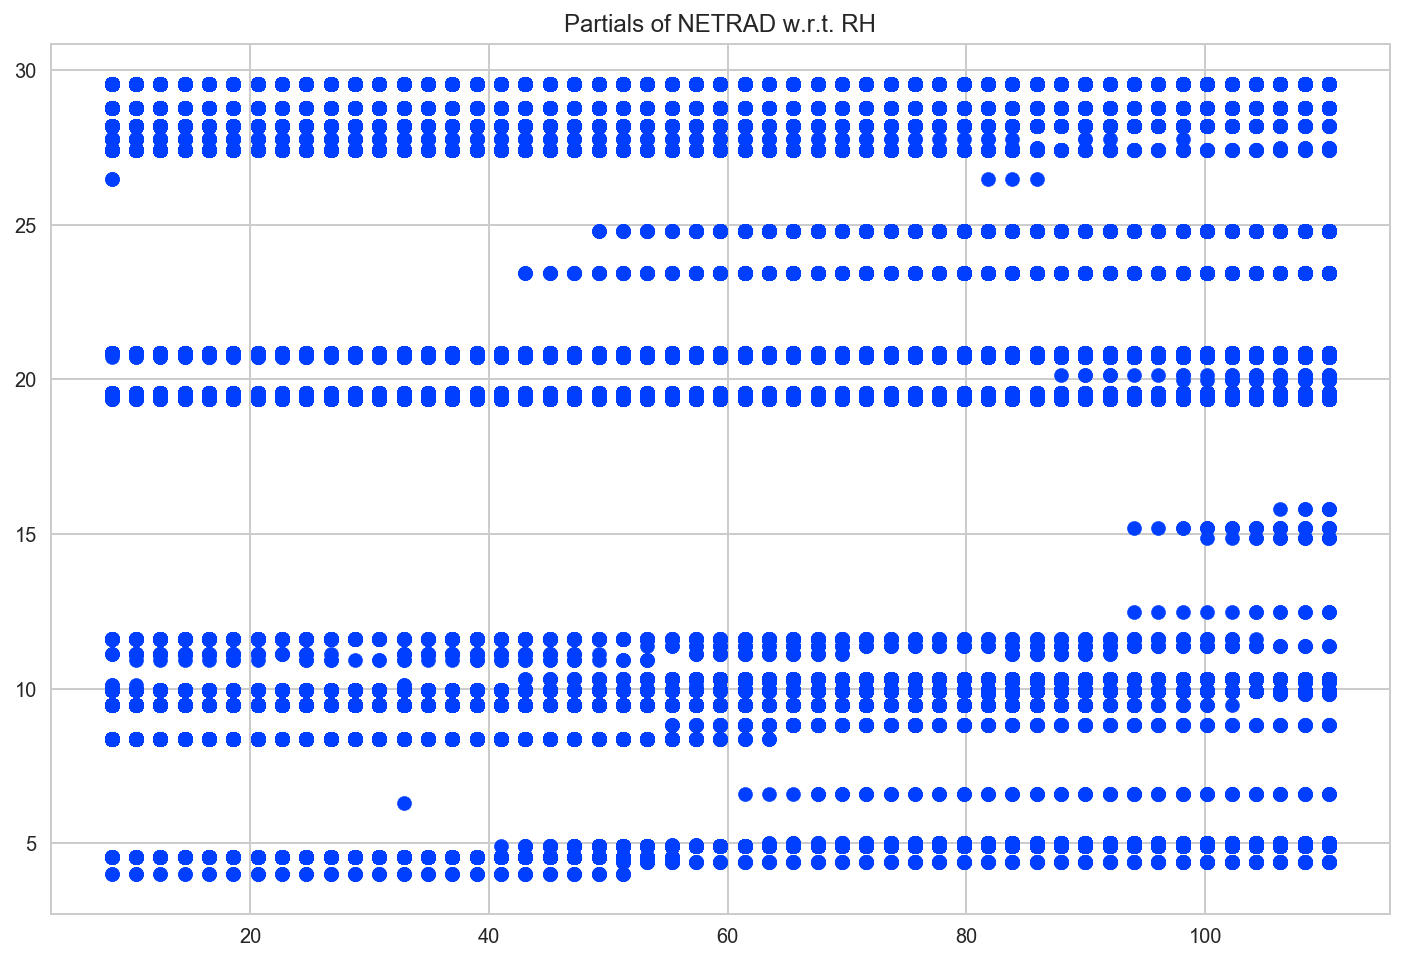

In [22]:
plt.title("Partials of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_uniform)[:, 2], uniform_partials[0][:, 2])

## Gaussian Predcitions/Partials

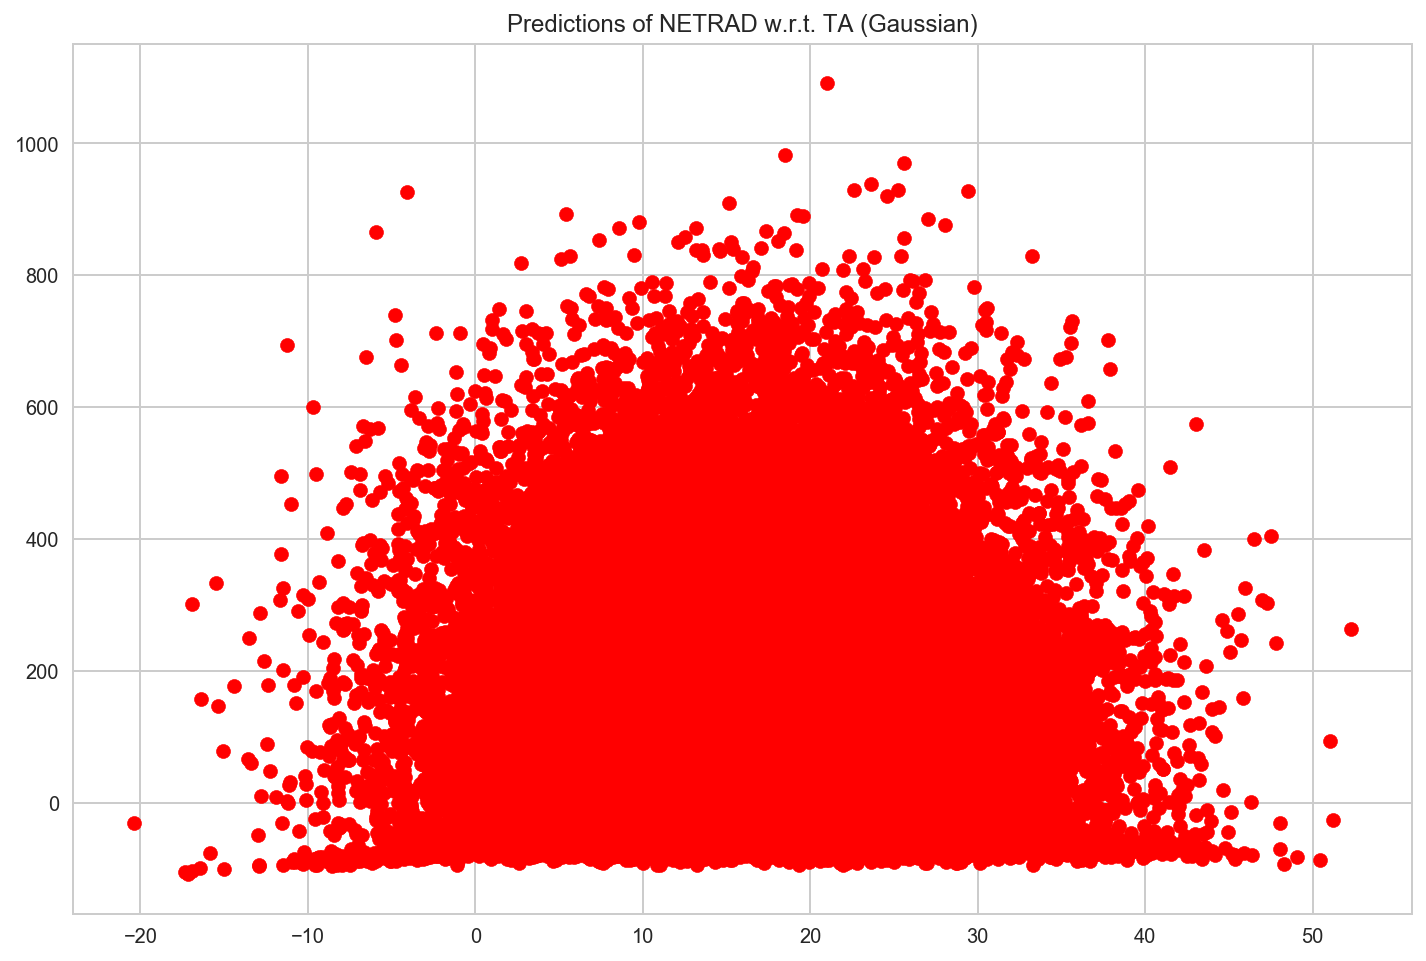

In [23]:
plt.title("Predictions of NETRAD w.r.t. TA (Gaussian)")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 0], gauss_preds[:, 0], c='r')

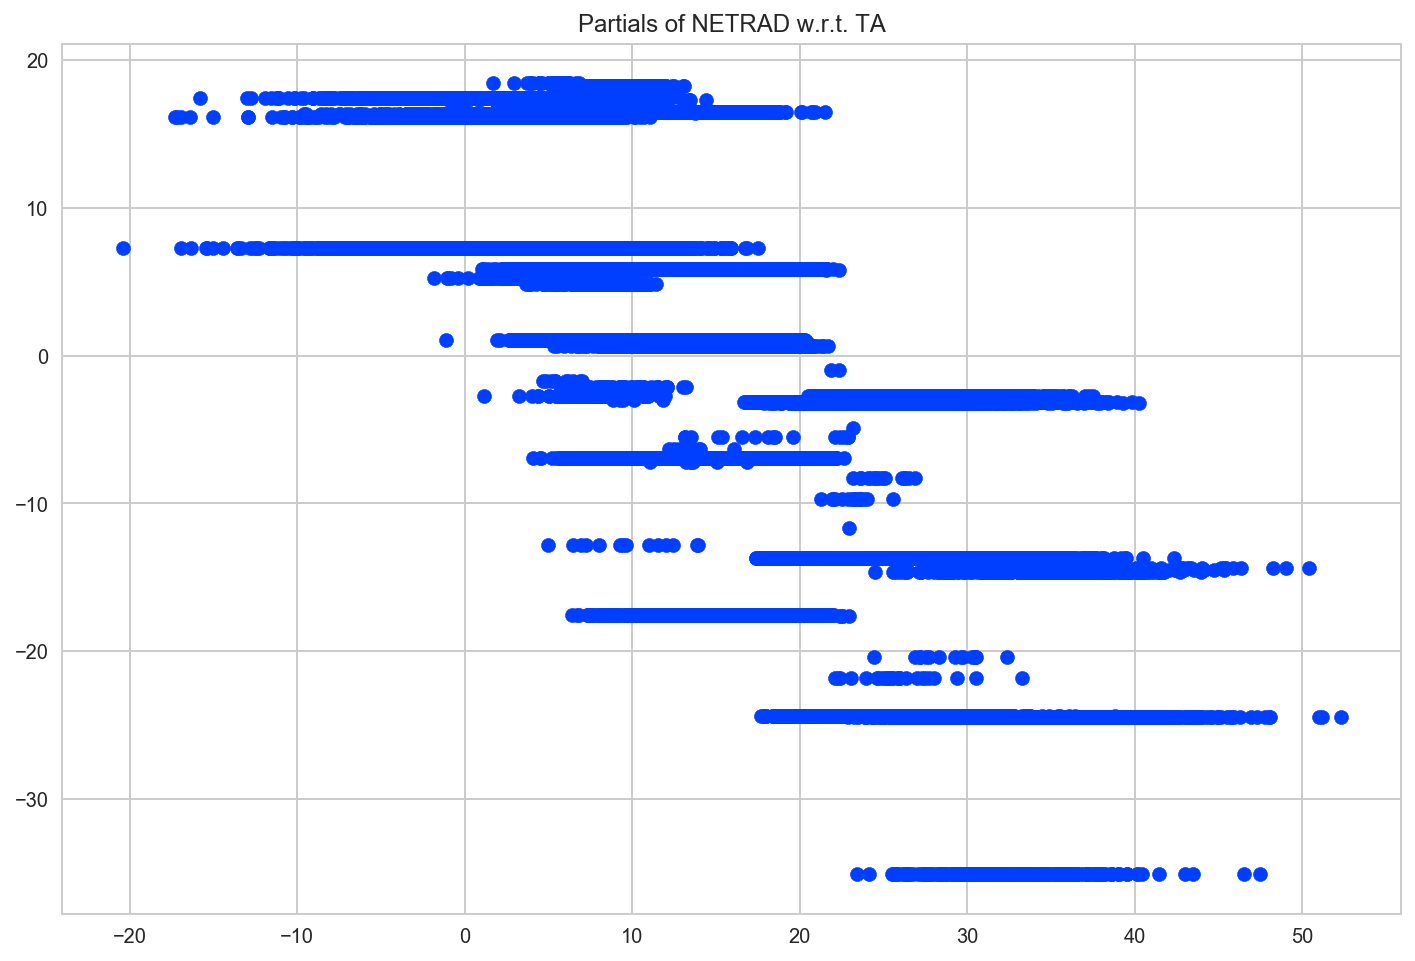

In [24]:
plt.title("Partials of NETRAD w.r.t. TA")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 0], gauss_partials[0][:, 0])

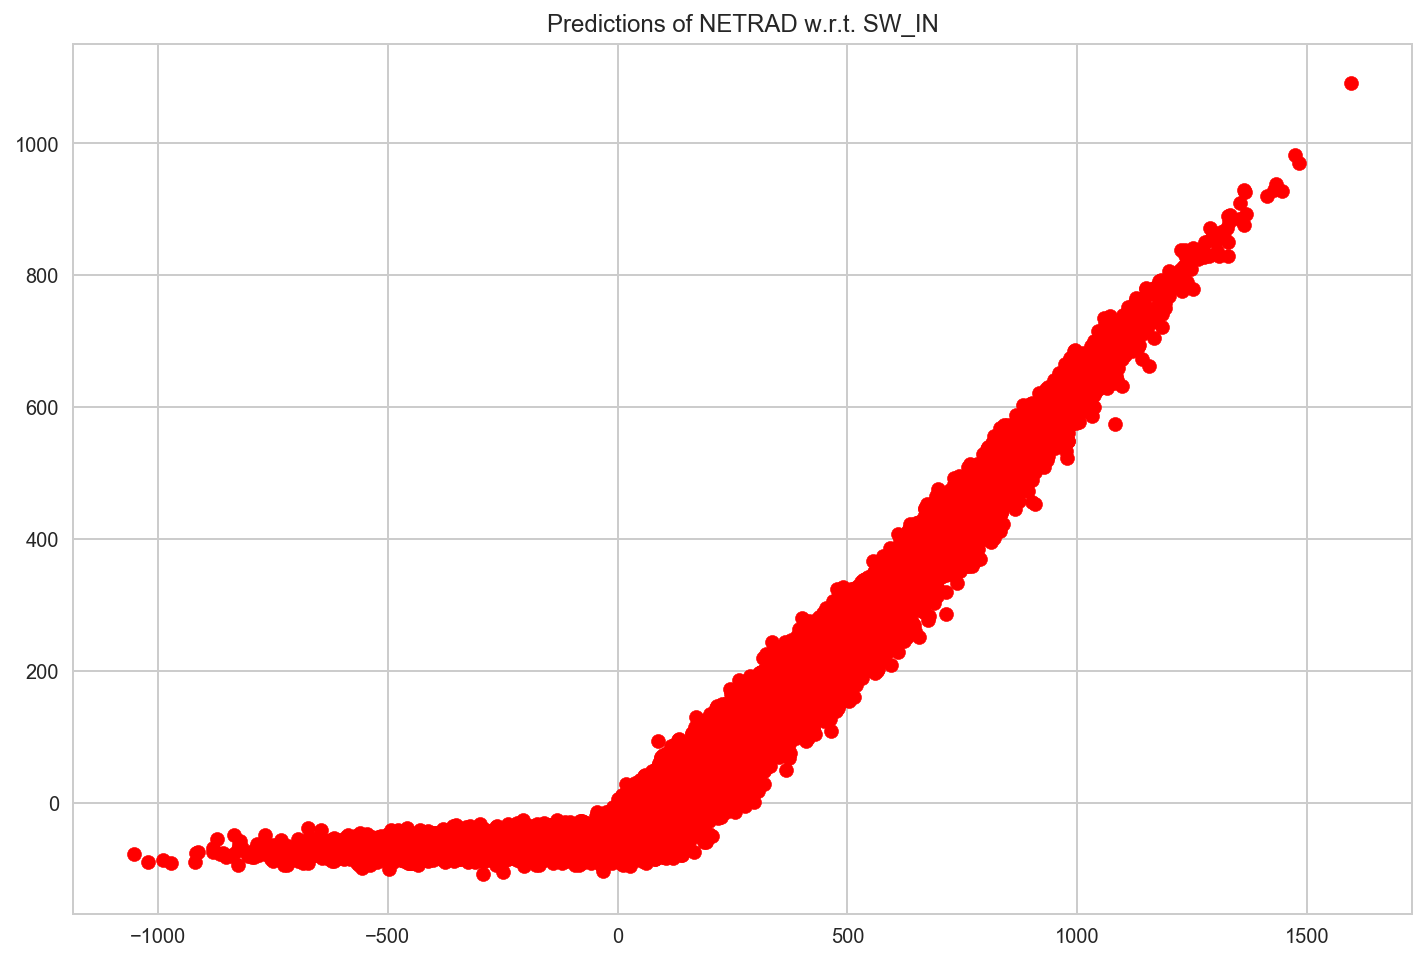

In [25]:
plt.title("Predictions of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 1], gauss_preds[:, 0], c='r')

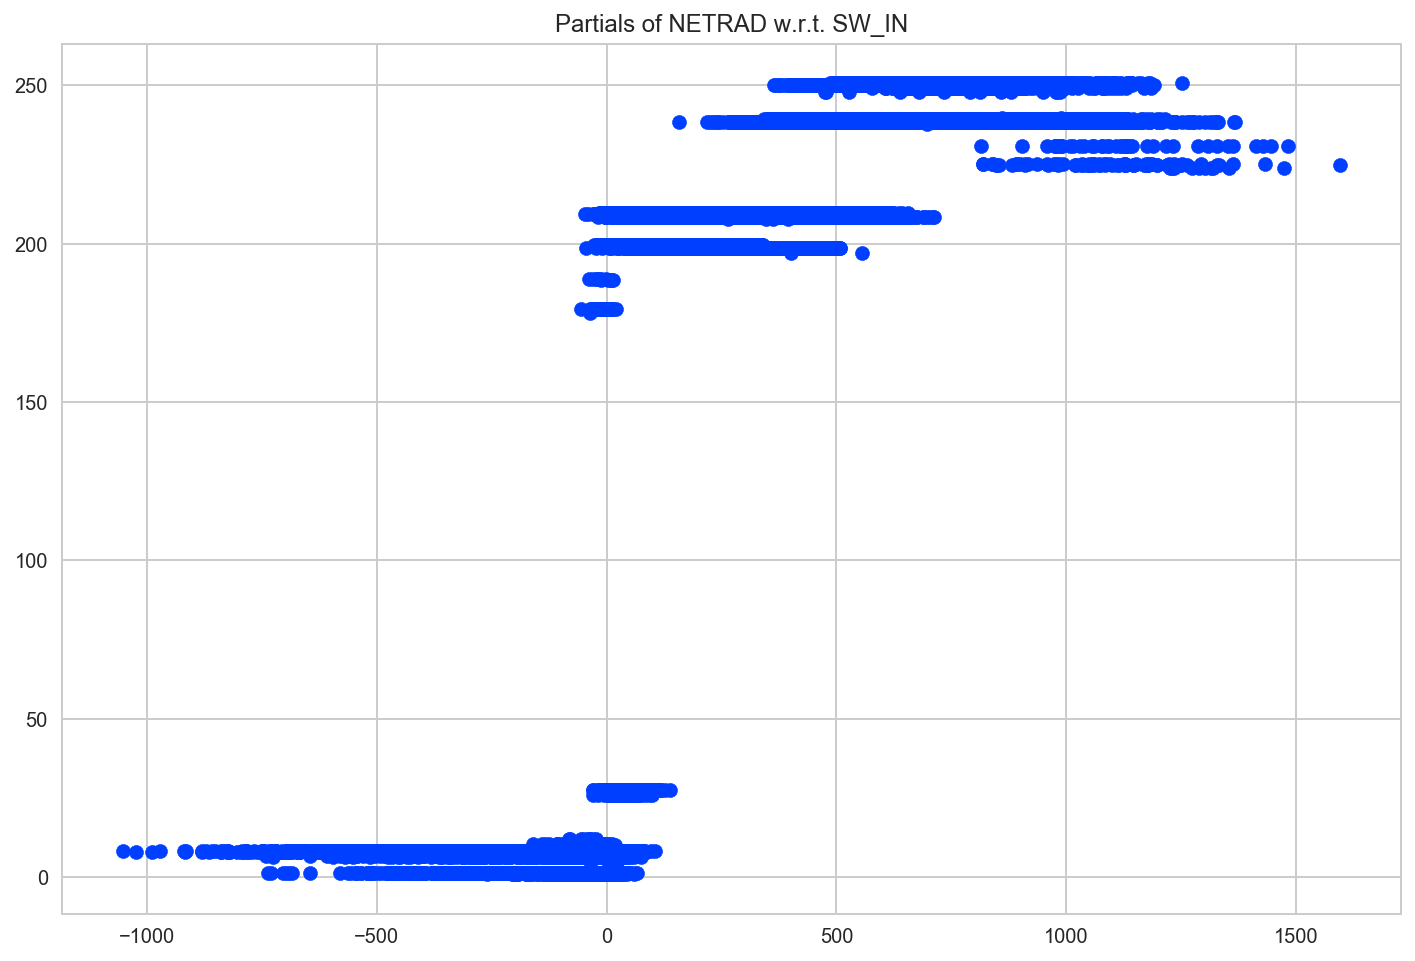

In [26]:
plt.title("Partials of NETRAD w.r.t. SW_IN")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 1], gauss_partials[0][:, 1])

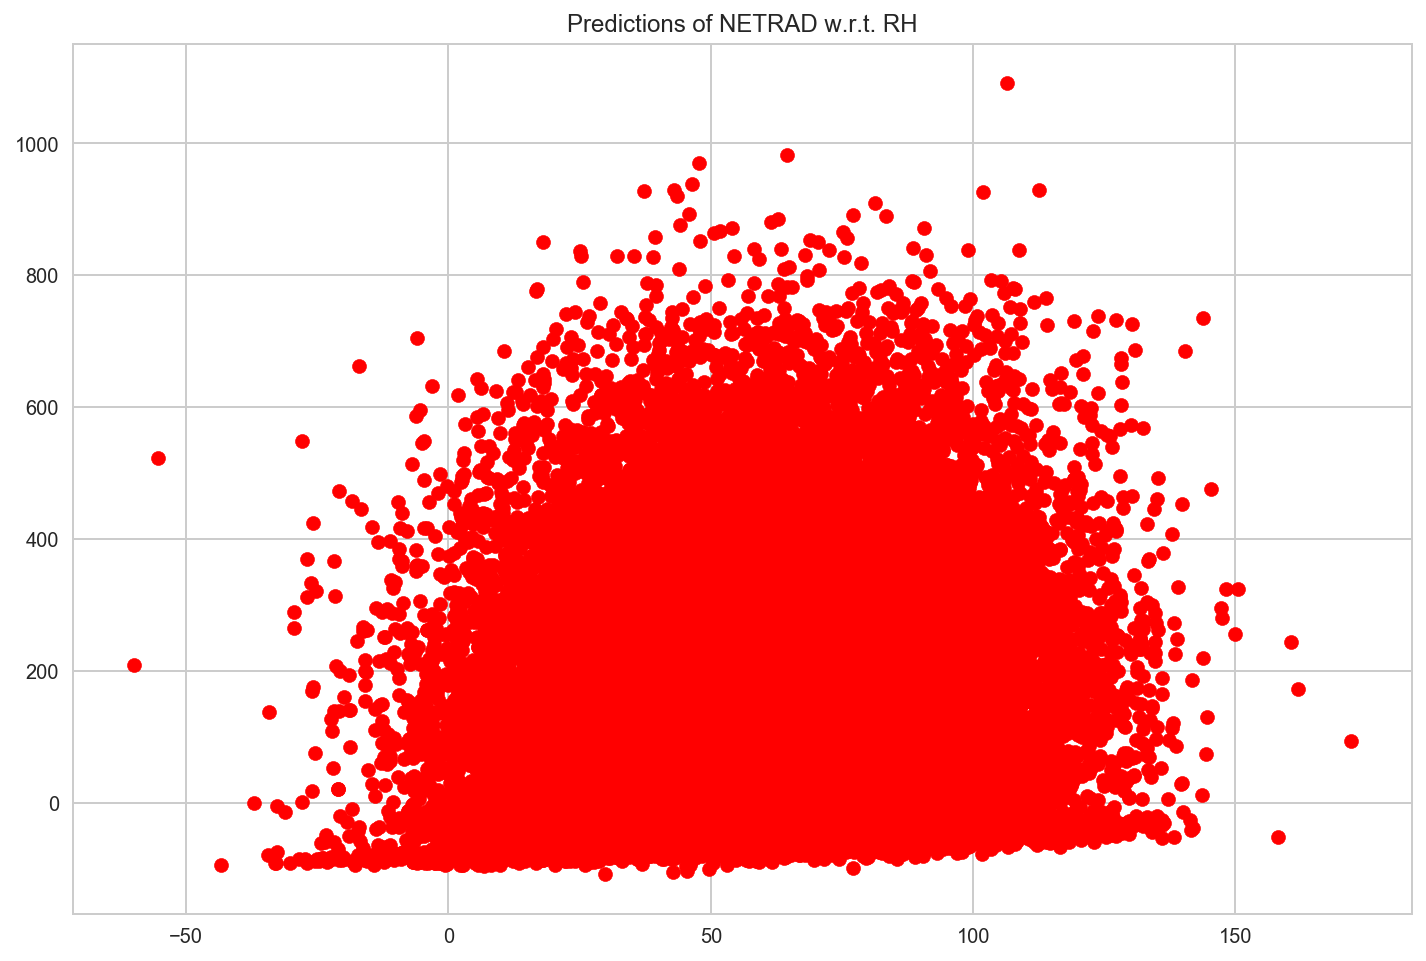

In [27]:
plt.title("Predictions of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 2], gauss_preds[:, 0], c='r')

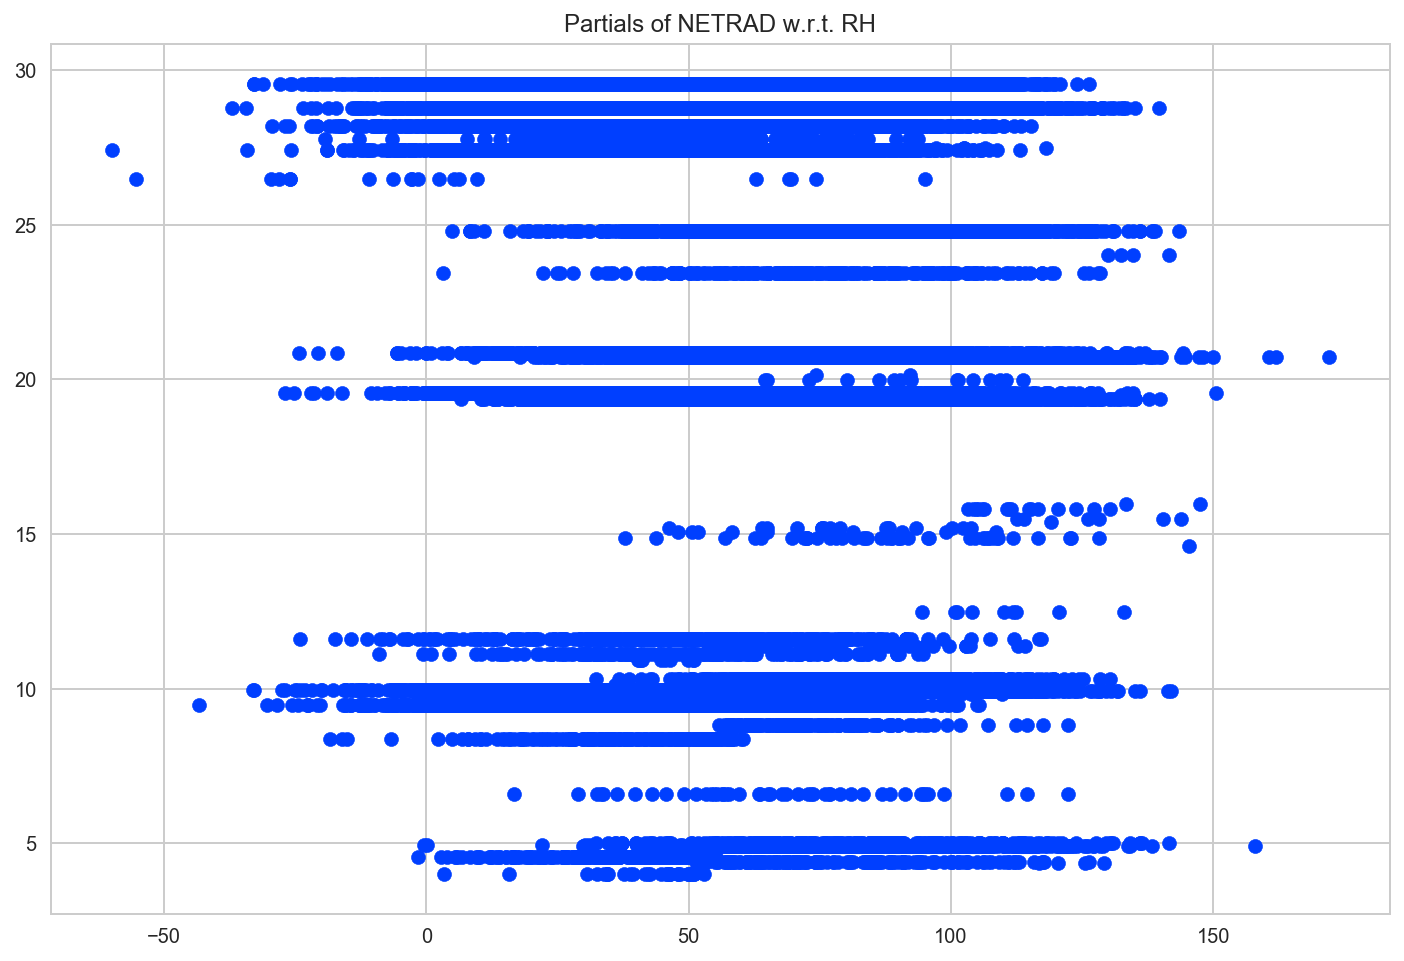

In [28]:
plt.title("Partials of NETRAD w.r.t. RH")
plt.scatter(X_scaler.inverse_transform(X_gaussian)[:, 2], gauss_partials[0][:, 2])